# Classifying images of different dog breeds with neural networks.

This notebook builds a multi-class image classifier using a neural network with TensorFlow and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog gives an image of a dog.

## 2. Data

The data being used is from [Kaggle's](https://www.kaggle.com/competitions/dog-breed-identification) dog breed identification competition.

## 3. Evaluation

The [evaluation](https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation) is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's best to use deep learning/transfer learning.
* There are 120 breeds of dog.
* There are approximately 10,000+ images in the training set (these images have labels).
* There are approximately 10,000+ images in the test set (these images have no labels since we need to predict them).

### Get our workspace ready

* Import TensorFlow
* Import TensorFlow Hub
* Make sure we're using a GPU

In [ ]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


## Getting our data ready (turning it into Tensors)

With all machine-learning models, our data has to be in numerical format. So we'll turn our images into Tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [ ]:
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

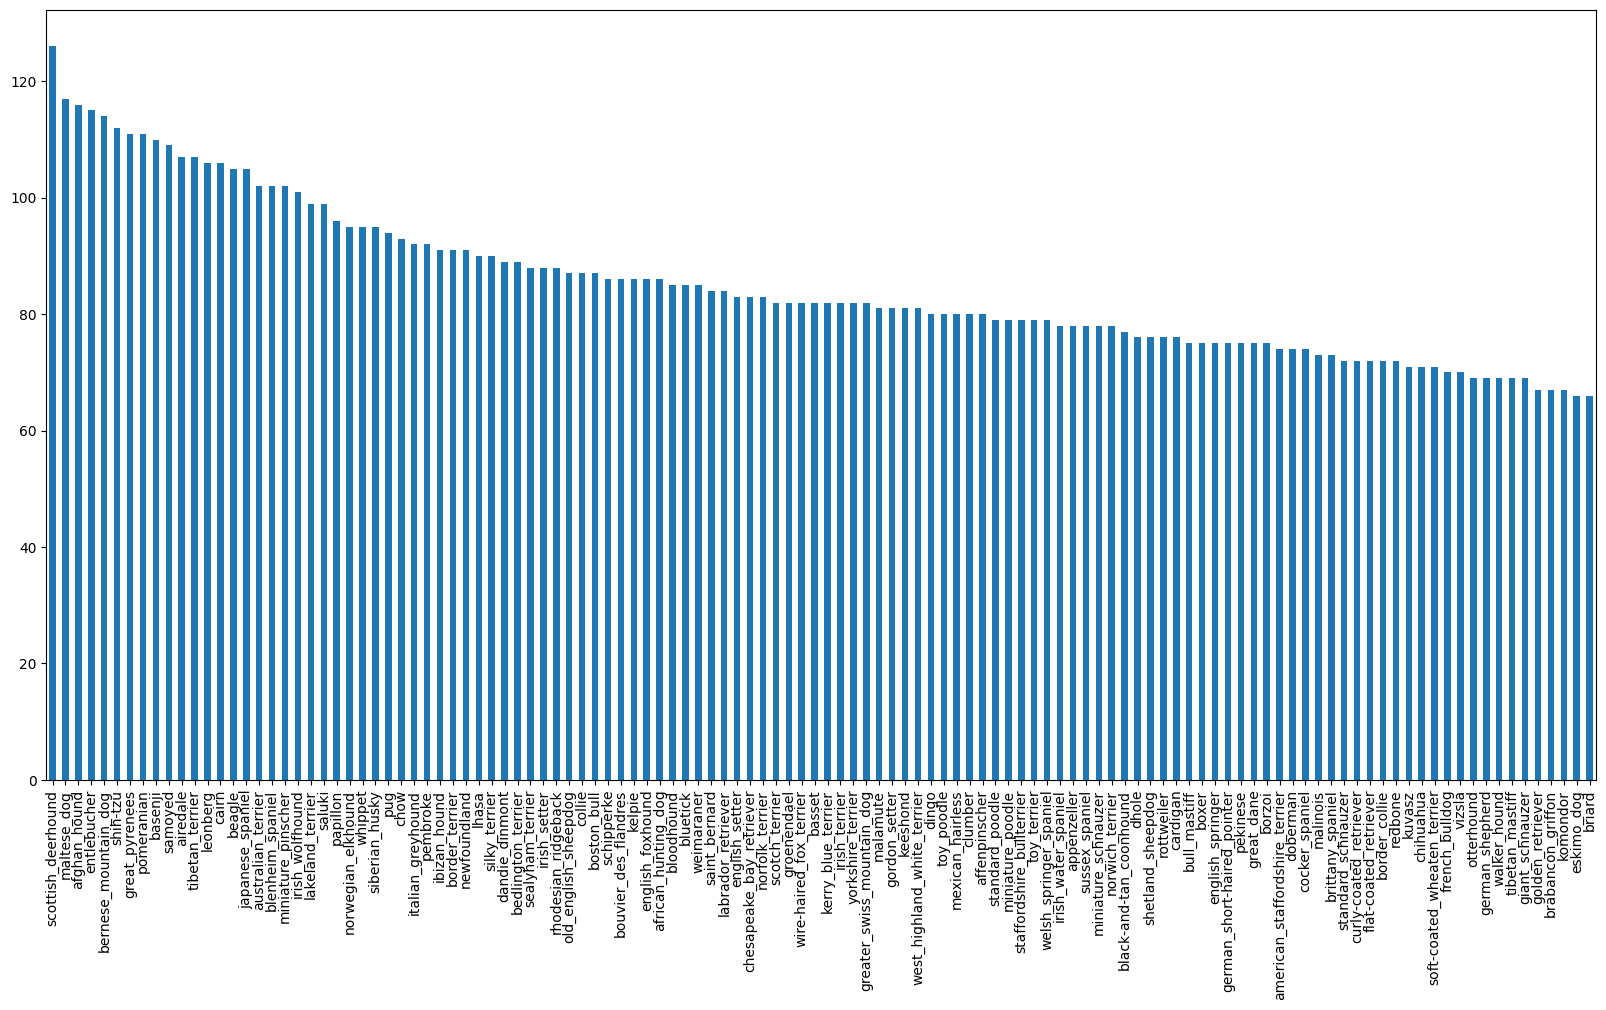

In [ ]:
# How many images are there for each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

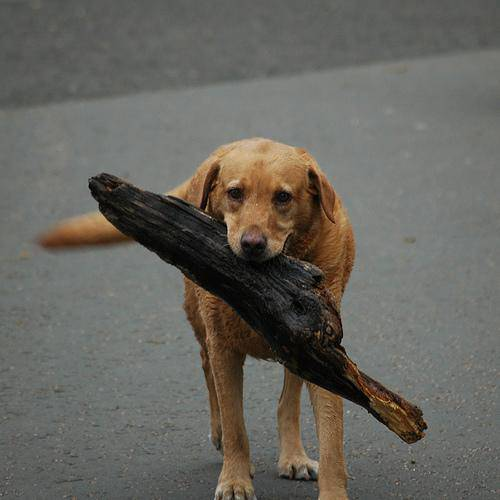

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files. Proceed.")
else:
  print("Filenames do not match actual amount of files.")

Filenames match actual amount of files. Proceed.


Since we've now got our training image filepaths in a list, let's prepare out labels.

In [ ]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

We'll also see if the number of labels matches the number of filenames.

In [ ]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames.")

Number of labels matches number of filenames.


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning boolean array into intgers
print(labels[0]) # originial label
print()
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where teh sample occurs

boston_bull

(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle does not come with a validation set, we're going to have to make one ourselves.


In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimentiong with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

# Make sure our data are the same shapes for the training and validation sets
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Peek at training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3) # channels=3 for RGB

  # Convert the color channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go, they all might not fit into memory.

So that's why we do about 32 (batch size) images at a time.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and associated label,
  process the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches.

In [ ]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into baches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data our of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

our data is now in batches, however, these can be a little hard to understand/comprehend. Let's visualize them.

In [ ]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(12, 12))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1) # row, col, index

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")

In [ ]:
# Convert the dataset into an iterator that produces batches of data in the form of NumPy arrays to visualize
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.01466016, 0.02048124, 0.10102221],
          [0.10853535, 0.17501819, 0.2347346 ],
          [0.17554995, 0.32319528, 0.35515434],
          ...,
          [0.6208488 , 0.5071233 , 0.35026053],
          [0.58320177, 0.4694763 , 0.31261355],
          [0.5797605 , 0.46603498, 0.3091722 ]],
 
         [[0.04146237, 0.00734632, 0.06890825],
          [0.06724204, 0.07879666, 0.13080998],
          [0.06061496, 0.14525029, 0.17290337],
          ...,
          [0.5515334 , 0.44565102, 0.27444854],
          [0.5393095 , 0.43342713, 0.2630008 ],
          [0.51253146, 0.40664914, 0.23750663]],
 
         [[0.07627776, 0.00120798, 0.03156488],
          [0.06053047, 0.01485241, 0.04539566],
          [0.01117568, 0.02637671, 0.03804766],
          ...,
          [0.6404772 , 0.53459483, 0.35140416],
          [0.60844606, 0.5025637 , 0.32050678],
          [0.598004  , 0.49212164, 0.31194004]],
 
         ...,
 
         [[0.9519088 , 0.8308908 , 0.94525623],
          [0.94587

In [ ]:
len(train_images), len(train_labels)

(32, 32)

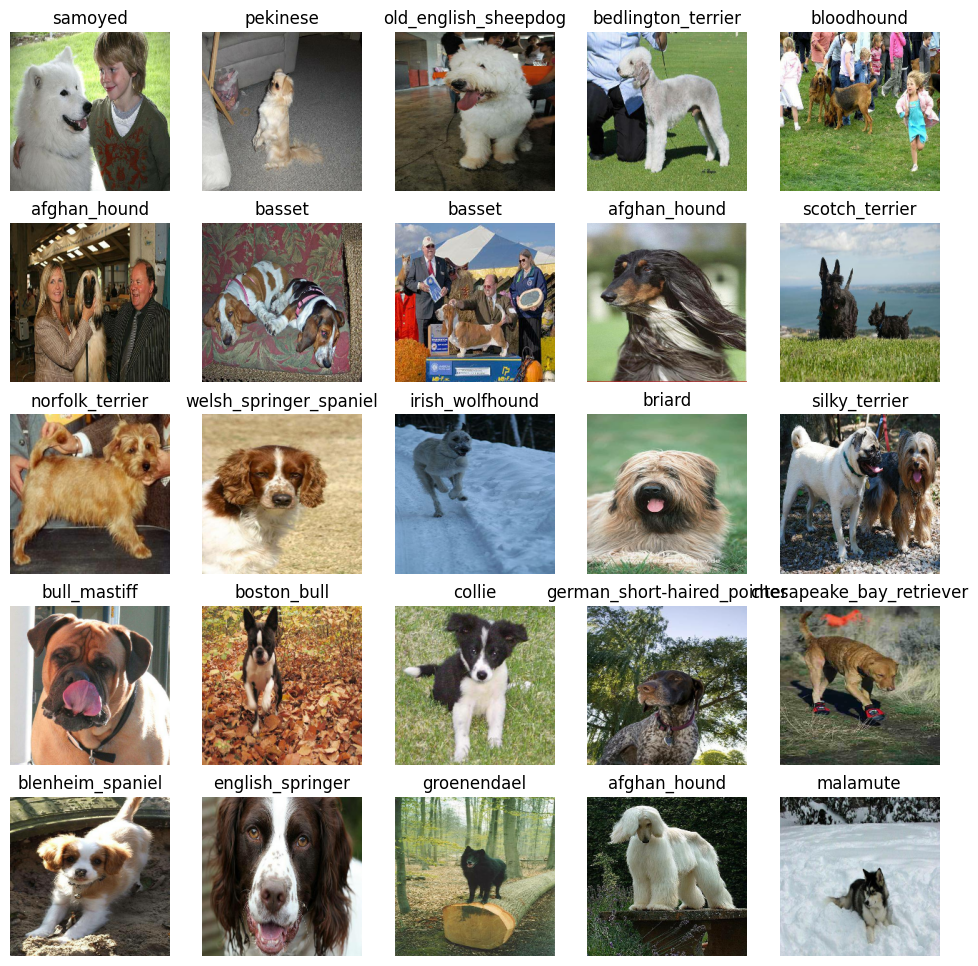

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

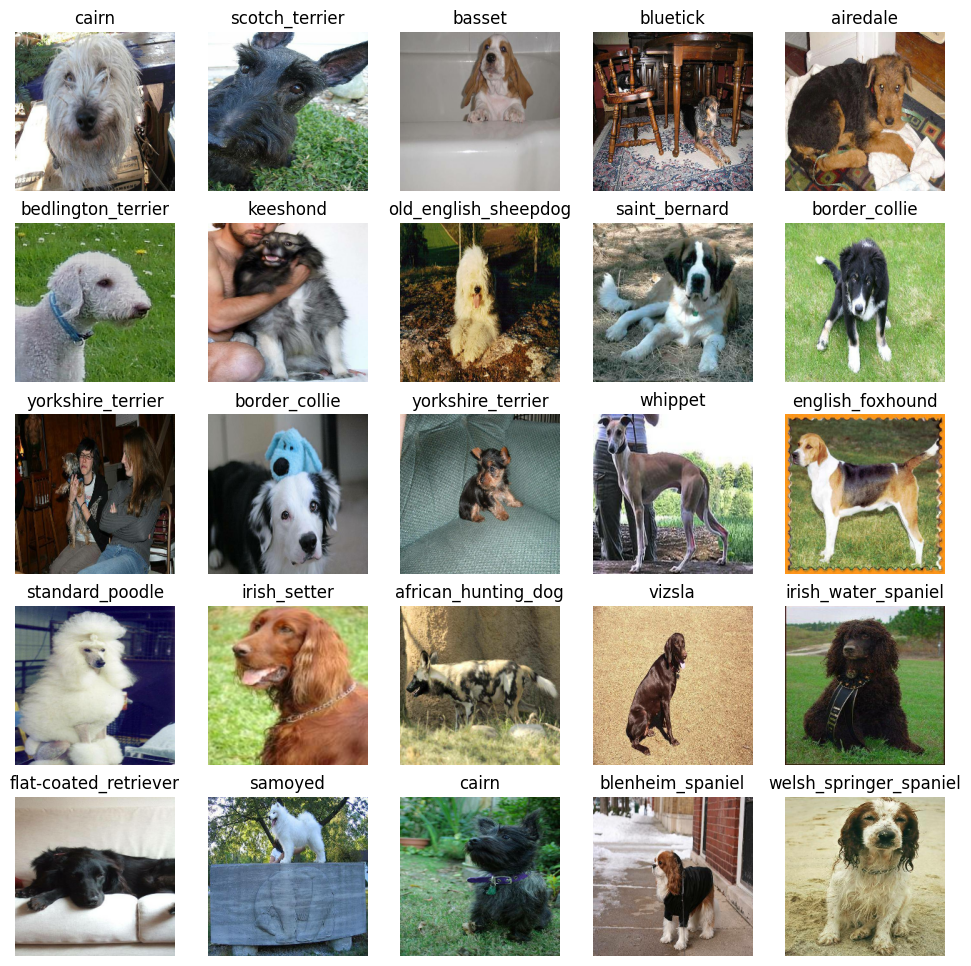

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from [TensorFlow Hub.](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs, and model ready to go. Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Define the layers in a Keras model in a sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Build the model (tell the model the input shape it'll be getting).
* Return the model.

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to save its progress, check its progress, or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our model's progress, and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To set up a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback that is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our model's training logs with the `%tensorboard` magic function.

In [ ]:
# Load TensorBoard notebook exention
%load_ext tensorboard

In [ ]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

## Training a model (on a subet of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
# How many times our model can look at the training set
NUM_EPOCHS = 100 # @param {type: "slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model.

* Create a model using `create_model()`,
* Setup a TensorBoard callback using `create_tensorboard_callback()`,
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 143s 5s/step - loss: 4.5879 - accuracy: 0.0962 - val_loss: 3.3732 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 3s 106ms/step - loss: 1.6351 - accuracy: 0.6750 - val_loss: 2.1527 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 4s 158ms/step - loss: 0.5676 - accuracy: 0.9488 - val_loss: 1.6787 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 3s 107ms/step - loss: 0.2510 - accuracy: 0.9837 - val_loss: 1.5095 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 3s 103ms/step - loss: 0.1457 - accuracy: 0.9975 - val_loss: 1.4490 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 141ms/step - loss: 0.1002 - accuracy: 1.0000 - val_loss: 1.4031 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================]

It looks like our model is overfitting because it is performing far better on the training data than the validation set.

### Checking the TensorBoard logs

The TensorBoard magic funtion (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

Reusing TensorBoard on port 6006 (pid 7853), started 0:01:14 ago. (Use '!kill 7853' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 83ms/step


array([[1.0742119e-03, 5.3001073e-05, 2.7964653e-03, ..., 9.2564755e-05,
        2.8308166e-05, 7.4782274e-03],
       [2.0100032e-03, 6.3873292e-04, 1.0315703e-02, ..., 1.1290499e-04,
        1.5883133e-04, 7.1618277e-05],
       [1.0622761e-05, 1.4907350e-04, 2.3077746e-06, ..., 1.9274937e-04,
        3.2322983e-05, 1.1352644e-03],
       ...,
       [5.9678991e-06, 2.7850127e-05, 5.8151440e-06, ..., 8.5601805e-06,
        1.1502720e-04, 4.0248971e-05],
       [1.4818087e-03, 8.5902735e-05, 6.3567451e-05, ..., 6.8183544e-05,
        2.5096340e-05, 3.8669745e-03],
       [2.6289123e-04, 4.3002219e-05, 2.3600887e-04, ..., 1.7456324e-03,
        1.1971445e-03, 1.3646347e-04]], dtype=float32)

In [ ]:
# First prediction
index = 42
print(f"Max Value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Max Value (probability of prediction): 0.5851872563362122
Sum: 1.0
Max Index: 113
Predicted label: walker_hound


Having the above functionality is great but we want to be able to do it at scale. And it would be even better if we could see the image the prediction is being made on.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])

In [ ]:
pred_label

'border_terrier'

Now since our validation data is still in a batch dataset. we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to visualize all these features.

We'll create a function that:
* Takes an array of prediction probabilities, an array of truth labels, an array of images, and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label, and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

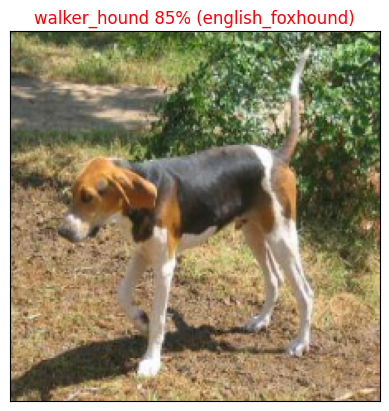

In [ ]:
# View an example prediction, original image and truth label
# Prediction wrong example
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=42)

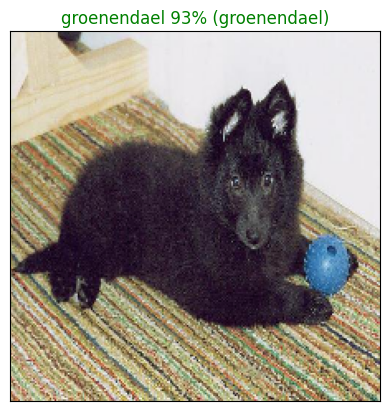

In [ ]:
# Prediction correct example
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our model's top prediction, let's make another function to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array, ground truth array, and an integer.
* Find the prediction label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probability values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest predictions confidences along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1] # [::-1] Puts it in descending order

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values, # Prediction probabilities
                     color="gray")

  # Show names of breeds on x-axis
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

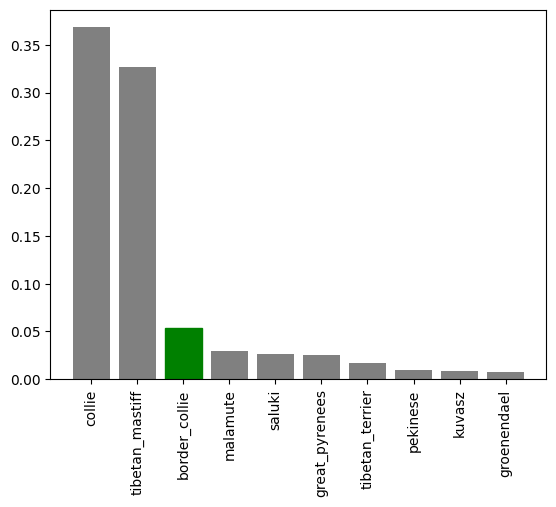

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help visualize our model's predictions and evaluate our model.

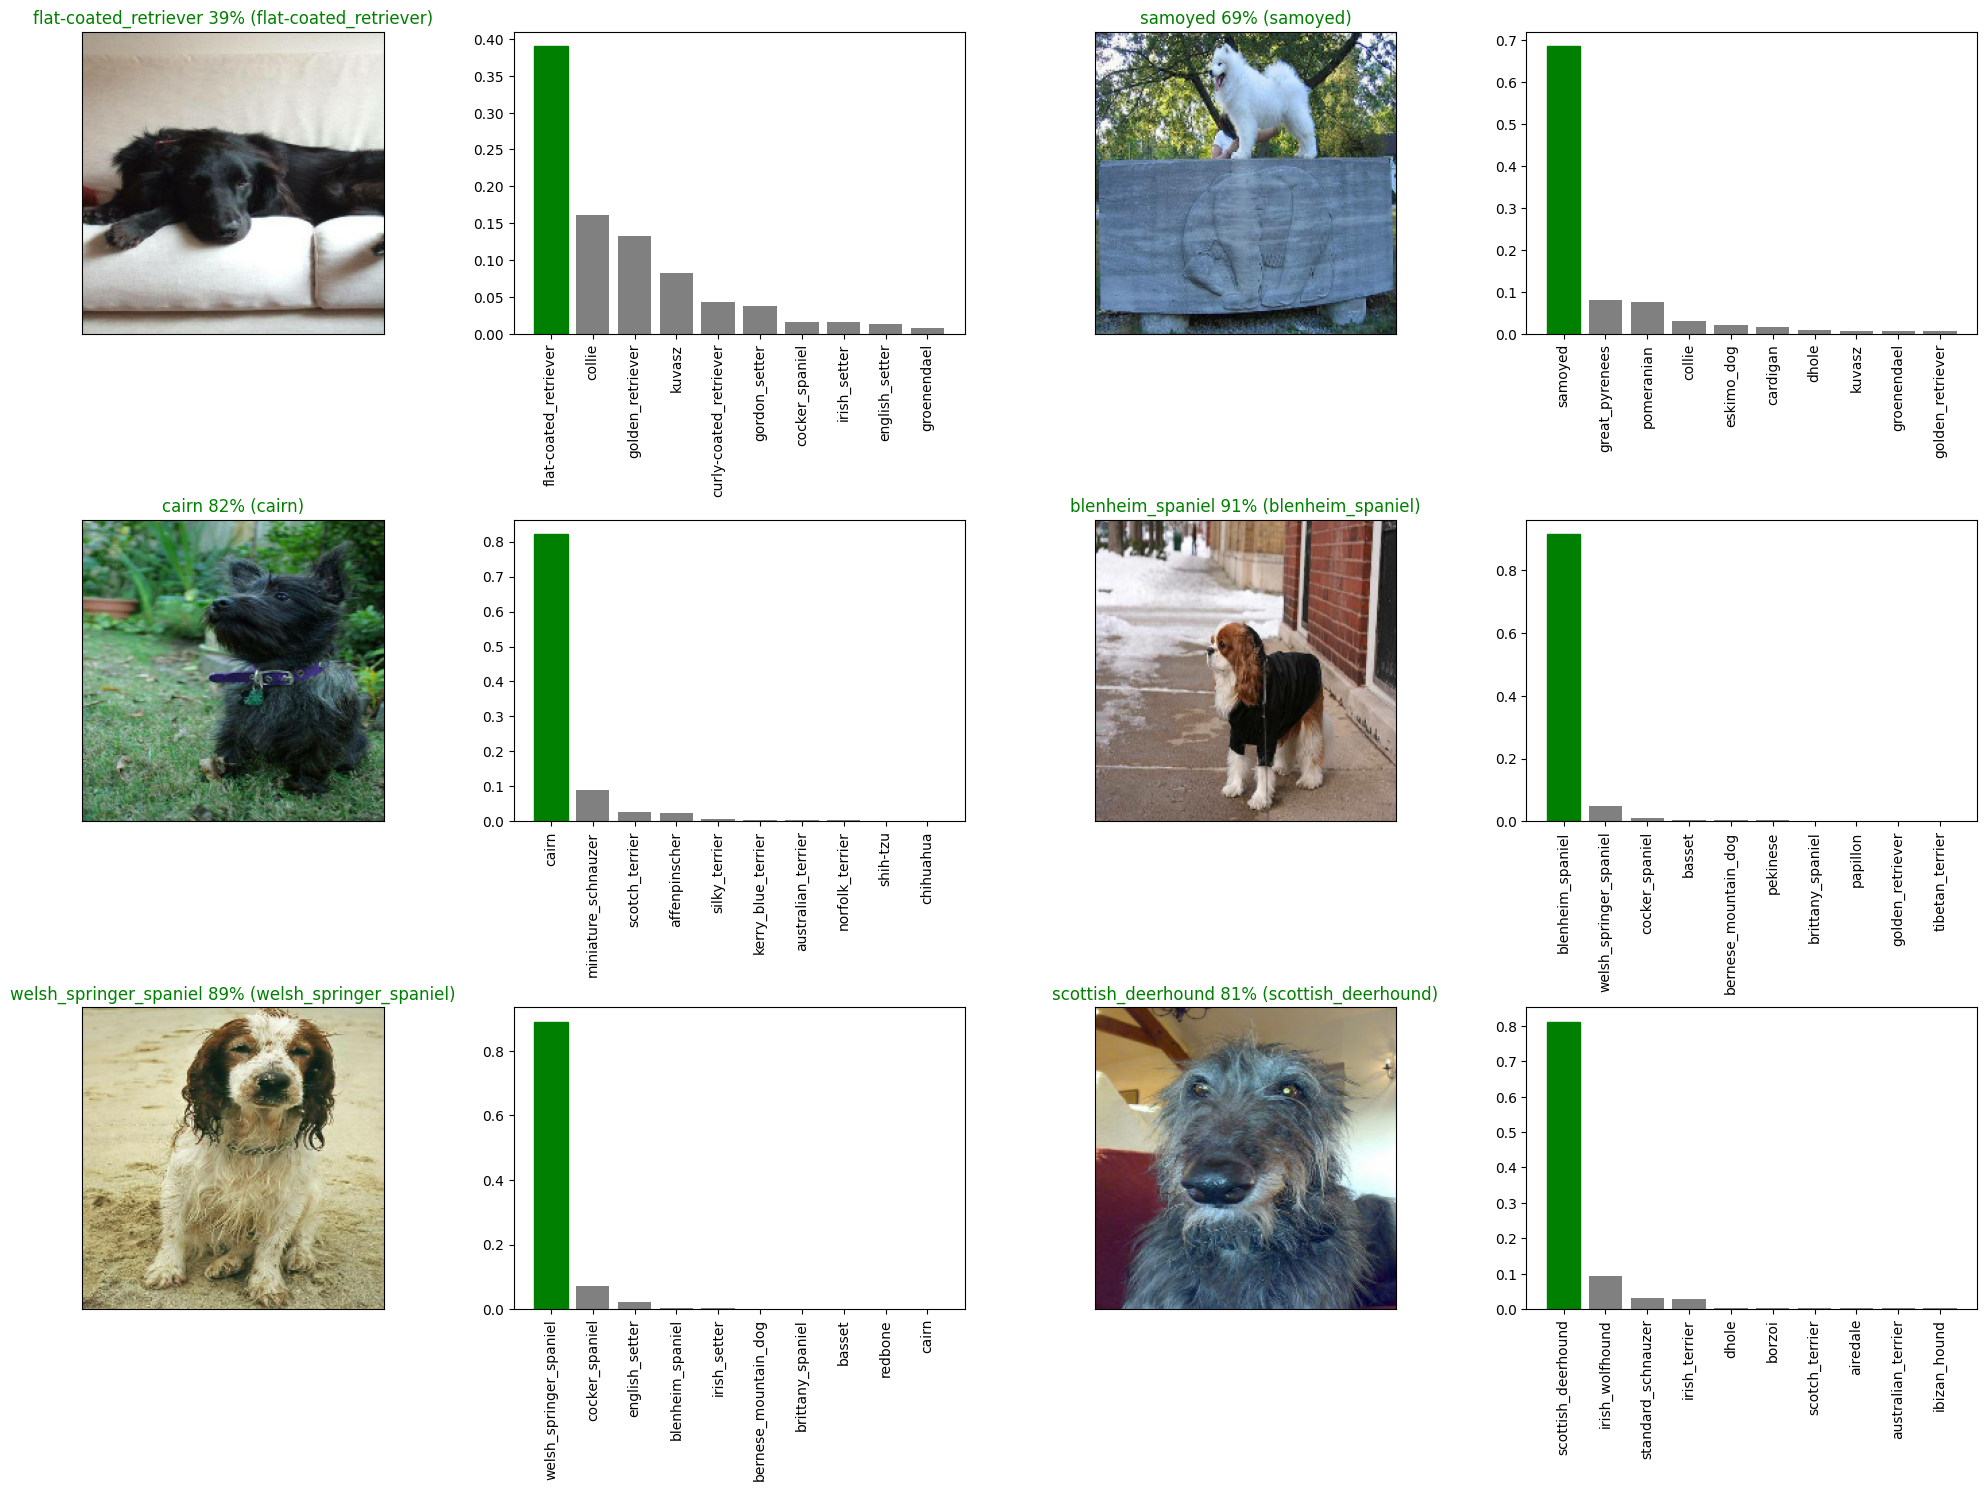

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0) # Give space between images and graphs
plt.show()

Before we save our model, let's look at a confusion matrix to see where our model has trouble in classifying the labels to the true labels.

Text(0.5, 1.0, 'Confusion Matrix for Dog Vision')

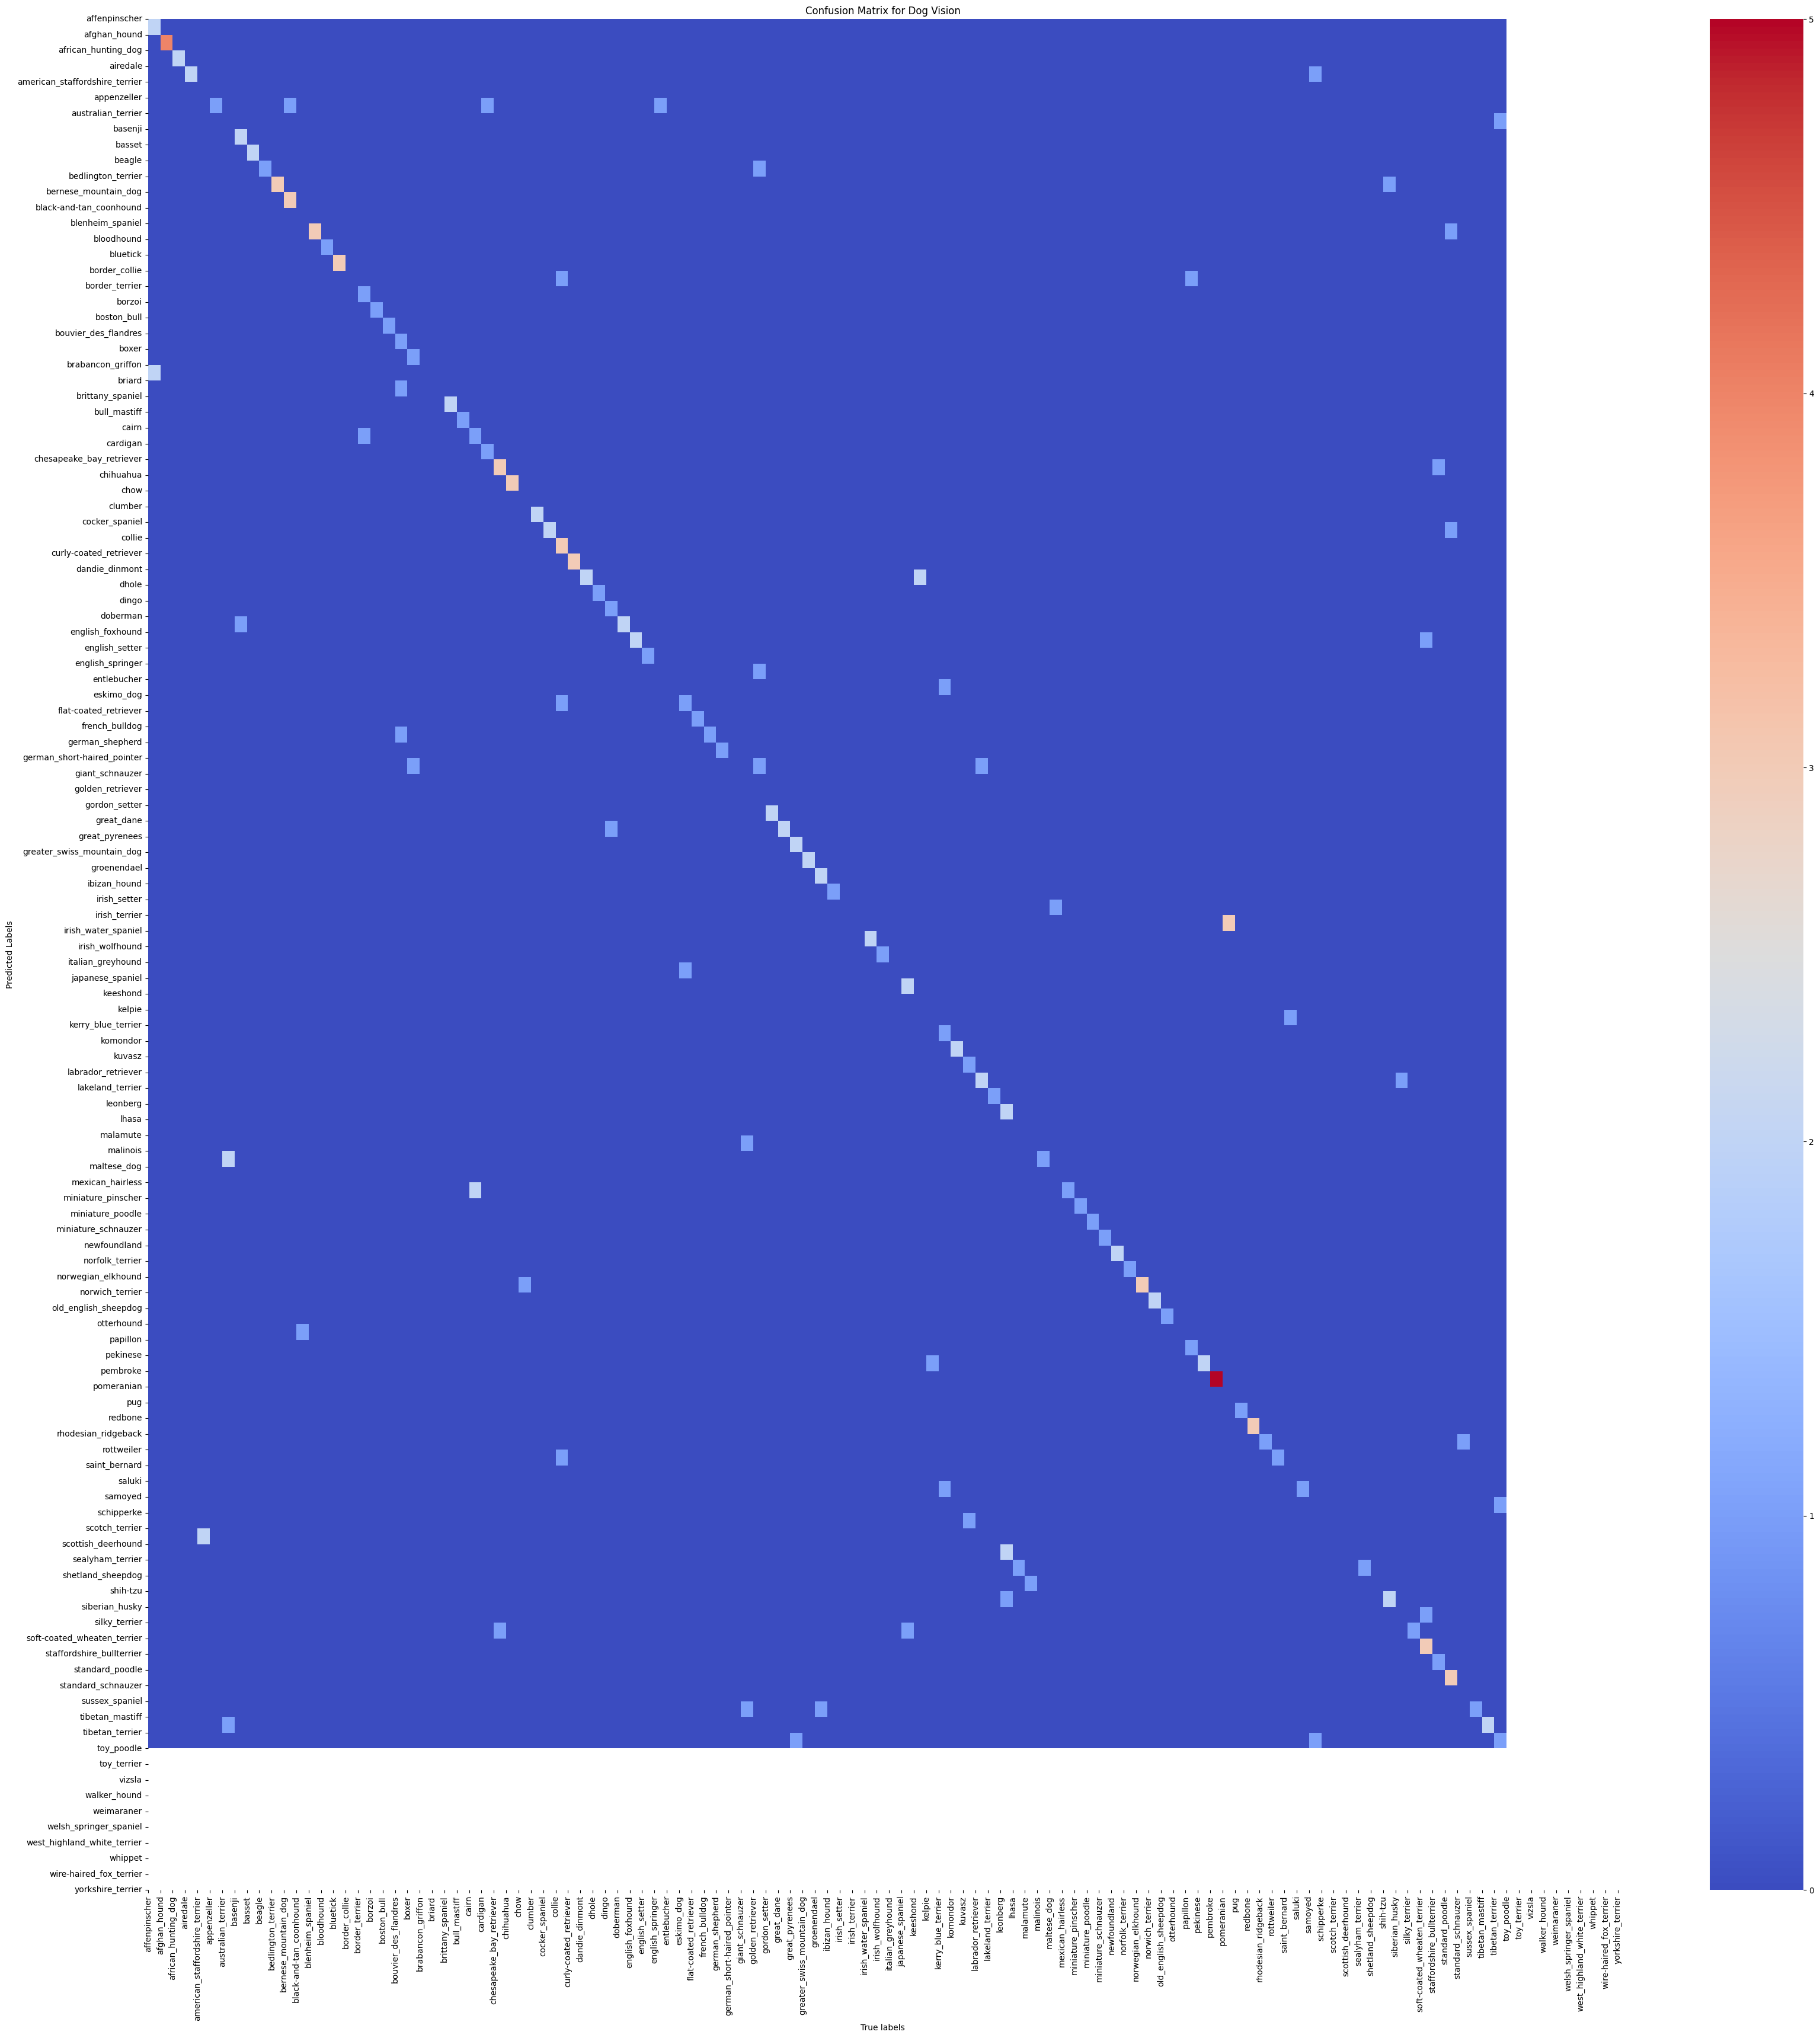

In [ ]:
# Create confusion matrix

# Get predicted labels
y_preds = np.array([get_pred_label(i) for i in predictions])

conf_matrix = confusion_matrix(val_labels, y_preds)

plt.figure(figsize=(40, 41))
sns.heatmap(conf_matrix, cmap="coolwarm")

plt.ylabel("Predicted Labels")
plt.xlabel("True labels")

plt.xticks(ticks=np.arange(120), labels=unique_breeds)  # plot the breed name on axix
plt.yticks(ticks=np.arange(120), labels=unique_breeds, rotation='horizontal')

plt.title("Confusion Matrix for Dog Vision")

## Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a model's directory and appends a suffix (stirng).
  """

  # Create a model directory path name with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """

  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a trained model, let's make sure they work.

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230803-03431691034214-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20230803-03431691034214-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/MyDrive/Dog Vision/models/20230803-03431691034214-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog Vision/models/20230803-03431691034214-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 120ms/step - loss: 1.1866 - accuracy: 0.6800


[1.1866189241409302, 0.6800000071525574]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 104ms/step - loss: 1.1866 - accuracy: 0.6800


[1.1866189241409302, 0.6800000071525574]

## Training our model on the full dataset

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**NOTE:** Running the cell below will take a long time (at least 30 minutes) since we have to load all the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1111s 3s/step - loss: 1.3383 - accuracy: 0.6681
Epoch 2/100
320/320 [==============================] - 37s 117ms/step - loss: 0.4015 - accuracy: 0.8818
Epoch 3/100
320/320 [==============================] - 39s 120ms/step - loss: 0.2368 - accuracy: 0.9373
Epoch 4/100
320/320 [==============================] - 38s 118ms/step - loss: 0.1551 - accuracy: 0.9651
Epoch 5/100
320/320 [==============================] - 39s 123ms/step - loss: 0.1067 - accuracy: 0.9801
Epoch 6/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0755 - accuracy: 0.9877
Epoch 7/100
320/320 [==============================] - 40s 126ms/step - loss: 0.0588 - accuracy: 0.9910
Epoch 8/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0462 - accuracy: 0.9944
Epoch 9/100
320/320 [==============================] - 44s 138ms/step - loss: 0.0372 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 40s 125ms

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230809-00531691542388-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20230809-00531691542388-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
# Load the full model
loaded_full_model = load_model("drive/MyDrive/Dog Vision/models/20230809-00531691542388-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/20230809-00531691542388-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor Batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (test data has no labels).
* Make predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load test image filenames
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog Vision/test/e24b98741c9c780d7c5203def153f00c.jpg',
 'drive/MyDrive/Dog Vision/test/e73d52671c56e1507fed58c4c287d5f1.jpg',
 'drive/MyDrive/Dog Vision/test/e7b4b0e7d7d76f8dbd64920f34443b25.jpg',
 'drive/MyDrive/Dog Vision/test/e7b357150635c250757363718e4dae86.jpg',
 'drive/MyDrive/Dog Vision/test/e298c484aa05012775db02f3596e1d18.jpg',
 'drive/MyDrive/Dog Vision/test/e1f7ec4bd372612f53411026aaabf233.jpg',
 'drive/MyDrive/Dog Vision/test/dcae38083c0e6a8afe15b6f0703bdefa.jpg',
 'drive/MyDrive/Dog Vision/test/dcab2d03a686ab3f31d1bc3e5700f6d1.jpg',
 'drive/MyDrive/Dog Vision/test/e00a1b26edd5cb7323e3b75ce37b36f6.jpg',
 'drive/MyDrive/Dog Vision/test/df2b5cee4b3d8a3cb893b668df16d572.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about 1 hour).

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 1228s 4s/step


In [ ]:
# Save predictions
np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv",test_predictions, delimiter=",")

In [ ]:
# Load predictions
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[7.40710531e-12, 1.98654856e-10, 1.10516006e-10, ...,
        5.15933542e-13, 1.68865333e-09, 1.18622917e-10],
       [8.71119288e-10, 3.38789500e-12, 8.09828316e-11, ...,
        4.74127959e-11, 1.17915085e-12, 2.68190834e-11],
       [1.50781732e-09, 1.60874022e-10, 1.23528743e-08, ...,
        3.48102702e-07, 2.70013652e-06, 1.60368376e-08],
       ...,
       [2.41679777e-13, 3.69535985e-10, 6.94282210e-14, ...,
        1.61301636e-14, 6.17618902e-15, 5.02759401e-13],
       [1.60195452e-13, 1.53866218e-08, 5.35750819e-11, ...,
        2.31355518e-10, 4.37683923e-07, 8.77467787e-09],
       [1.46220627e-08, 1.34229259e-08, 2.49555671e-11, ...,
        9.12076636e-10, 1.83378579e-09, 8.80117739e-08]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at The [Kaggle sample submission](https://www.kaggle.com/competitions/dog-breed-identification/data?select=sample_submission.csv), we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [ ]:
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)] # We put [0] so it won't show .jpg
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e24b98741c9c780d7c5203def153f00c           NaN          NaN   
1  e73d52671c56e1507fed58c4c287d5f1           NaN          NaN   
2  e7b4b0e7d7d76f8dbd64920f34443b25           NaN          NaN   
3  e7b357150635c250757363718e4dae86           NaN          NaN   
4  e298c484aa05012775db02f3596e1d18           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e24b98741c9c780d7c5203def153f00c   7.407105e-12  1.986549e-10   
1  e73d52671c56e1507fed58c4c287d5f1   8.711193e-10  3.387895e-12   
2  e7b4b0e7d7d76f8dbd64920f34443b25   1.507817e-09  1.608740e-10   
3  e7b357150635c250757363718e4dae86   2.362890e-06  7.293924e-11   
4  e298c484aa05012775db02f3596e1d18   3.416188e-05  5.701525e-03   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.105160e-10  2.302475e-12                    3.878380e-12   
1         8.098283e-11  7.150600e-10                    6.601802e-11   
2         1.235287e-08  1.809234e-07                    1.774480e-04   
3         4.652213e-10  1.579756e-06                    3.412815e-07   
4         3.420207e-07  1.717851e-01                    2.278671e-08   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  6.644500e-12        5.715294e-07  2.971051e-11  1.447863e-09  ...   
1  8.045873e-06        3.303526e-11  8.188354e-11  4.061105e-11  ...   
2  5.604305e-09        4.371652e-09  1.762792e-10  1.441924e-06  ...   
3  7.859198e-10        5.854022e-04  5.224988e-07  9.263670e-09  ...   
4  2.753545e-08        1.566960e-06  9.916909e-08  2.582402e-05  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  4.537061e-09  9.032243e-11  1.510381e-11  5.395924e-13  4.096872e-11   
1  8.371179e-10  6.403734e-13  3.043393e-10  3.864853e-10  1.936816e-11   
2  1.202844e-08  2.815781e-09  6.062752e-01  1.549251e-03  2.064285e-02   
3  9.507132e-05  1.184031e-03  3.200987e-07  1.714329e-07  3.559386e-09   
4  4.193035e-05  6.029325e-06  7.180039e-05  4.812735e-06  1.677669e-07   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            8.259863e-13                 5.035763e-10  5.159335e-13   
1            2.173457e-09                 2.543141e-10  4.741280e-11   
2            2.322616e-10                 5.738036e-10  3.481027e-07   
3            3.989215e-08                 1.732389e-04  5.029021e-07   
4            2.475121e-08                 1.486542e-09  3.512867e-05   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.688653e-09       1.186229e-10  
1             1.179151e-12       2.681908e-11  
2             2.700137e-06       1.603684e-08  
3             4.458470e-09       2.678211e-05  
4             1.428442e-04       8.040423e-03  

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to CSV
preds_df.to_csv("drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.


In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/custom-images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/MyDrive/Dog Vision/custom-images/golden-retriever.jpg',
 'drive/MyDrive/Dog Vision/custom-images/husky.jpg',
 'drive/MyDrive/Dog Vision/custom-images/poodle.jpg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 1s/step


In [ ]:
custom_preds.shape

(3, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [ ]:
custom_pred_labels

['golden_retriever', 'siberian_husky', 'miniature_poodle']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

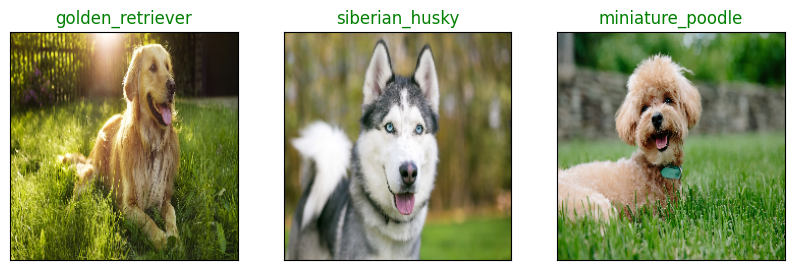

In [ ]:
true_labels = ["golden_retriever", "siberian_husky", "miniature_poodle"]

# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if custom_pred_labels[i] == true_labels[i]:
    color = "green"
  else:
    color = "red"

  plt.title(custom_pred_labels[i],
            color=color)
  plt.imshow(image)

Our model was able to get all 3 images above correct it has never seen before which is great.